# Can you make big money on Chinese stock IPO?

**Author**: [Spark Tseung](https://sparktseung.com)

**Source Code**: [github](https://github.com/sparktseung/Chinese-IPO) 

**Last Modified**: Sept 12, 2020

## Introduction

About two years ago, I started to have some extra money for investing. After a few trial-and-errors, I have resorted to regular purchase of a low-fee Exchange Traded Fund (ETF) tracking the US market index - the cost of "beating the market" just seems too high, and an average of 7~8% per year is already a very decent return.

I have been all content with that until a friend of mine mentioned the unbelievably high return on purchasing the Initial Public Offerings (IPO) of Chinese stocks. He claimed that, if you are lucky enough to be assigned some units during an IPO, the return on the first day of public trading is quite significant (e.g. 100%+). However, it is generally quite difficult to obtain those IPOs in the first place, so it is almost like buying a lottery.

Unfamiliar with, and intentially staying away from, the Chinese stock market, I was quite suspicious at first, but a quick search on the Internet has my confidence shaken. Therefore, being a student in statistics, I naturally started to dig into a pool of data, trying to find out if one can make some big money from Chinese stock IPOs. More specifically, I would like to see if one can make profits by obtaining stocks from IPOs and then selling them shortly after the public trading starts.

## Getting the data

There are not a lot of data source available for the issue prices of IPOs in the Chinese market. The best I can find is the `akshare` package in Python, which in turn pulls IPO data from [eastmoney](http://data.eastmoney.com/xg/xg/dxsyl.html), a Chinese stock broker. They have three datasets of IPO, `sh` for (mostly) bluechip stocks traded on the Shanghai Stock Exchange, and `zxb`/`cyb` for smaller companies traded on the Shenzhen Stock Exchange.

In [76]:
# Load required packages
import akshare as ak
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# IPO data for stocks traded on Shanghai Stock Exchange
# Mostly blue-chip stocks
ipo_shzb_df = ak.stock_em_dxsyl(market="上海主板")
# IPO data for stocks traded on Shenzhen Stock Exchange
# Mostly smaller companies
ipo_szzx_df = ak.stock_em_dxsyl(market="中小板")
ipo_szcy_df = ak.stock_em_dxsyl(market="创业板")

100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


The first few rows of the data set are shown below. After a quick view of the website tells that they have IPO data starting from year 2010. I will combine the three datasets, and change the column names in English. Since the datasets are frequently updated, we will focus on the decade of 2010-2019 only.

In [3]:
ipo_shzb_df.head(3)

,股票代码,股票简称,发行价,最新价,网上发行中签率,网上有效申购股数,网上有效申购户数,网上超额认购倍数,网下配售中签率,网下有效申购股数,网下有效申购户数,网下配售认购倍数,总发行数量,开盘溢价,首日涨幅,打新收益,上市日期,市场
0,605358,N立昂微,4.92,7.08,0.03197,114224888000,15990041,3127.56,0.00446855,90812500000,9112,22378.63,40580000,0.1992,0.4390,,2020-09-11,sh
1,605009,N豪悦,62.26,89.65,0.02382,100758868000,15783007,4197.76,0.01456494,18311100000,9316,6865.8,26670000,0.2000,0.4399,,2020-09-11,sh
2,605003,众望布艺,25.75,31.38,0.02346,84382582000,15347203,4261.75,0.01675539,13130100000,8208,5968.23,22000000,0.4400,0.4400,0.01,2020-09-08,sh


In [120]:
# Combine three datasets
ipo_df = pd.concat([ipo_shzb_df, ipo_szzx_df, ipo_szcy_df], ignore_index = True, sort = False)
# Rename columns in English
ipo_df.rename(columns={"股票代码": "ticker", "股票简称": "name",
                       "发行价": "price_issue", "最新价": "price_latest",
                       "网上发行中签率": "prob_online", "网上有效申购股数": "sub_size_online",
                       "网上有效申购户数": "subs_online","网上超额认购倍数": "over_online",
                       "网下配售中签率": "prob_offline", "网下有效申购股数": "sub_size_offline",
                       "网下有效申购户数": "subs_offline","网下配售认购倍数": "over_offline",
                       "总发行数量": "size_total", 
                       "开盘溢价": "list_premium", "首日涨幅": "return_firstday", 
                       "打新收益": "return_ipo", 
                       "上市日期": "list_date", "市场": "market"
                       }, inplace = True)
# The raw data are not in numeric
for i in range(2, 15):
    ipo_df.iloc[:, i] = pd.to_numeric(ipo_df.iloc[:, i])
# Filter by date: 2010-2019
ipo_df['list_date'] = pd.to_datetime(ipo_df['list_date'])
drop_idx = ipo_df[ (ipo_df['list_date'] > dt.datetime(2019, 12, 31)) ].index
ipo_df.drop(drop_idx , inplace = True)
ipo_df.dropna(inplace = True)

The combined and cleaned data set has 1942 records, and the variables are described as follows.

| Chinese          | English          | Description                                                                               |
|:------------------|:------------------|:-------------------------------------------------------------------------------------------|
| 股票代码         | ticker           | Ticker of the stock                                                                       |
| 股票简称         | name             | Name of the company                                                                       |
| 发行价           | price_issue      | Issue price (in CNY) of IPO, i.e. how much you pay per share before it goes public        |
| 最新价           | price_latest     | Latest trading price (in CNY)                                                             |
| 网上发行中签率   | prob_online      | Probability (in %) of successfully getting some IPO stocks, online application            |
| 网上有效申购股数 | sub_size_online  | Number of shares requested by potential IPO buyers, online application                    |
| 网上有效申购户数 | subs_online      | Number of potential IPO buyers, online application                                        |
| 网上超额认购倍数 | over_online      | How many people are competing for one successful online application, i.e. 1/prob_online   |
| 网下发行中签率   | prob_offline     | Probability (in %) of successfully getting some IPO stocks, offline application           |
| 网下有效申购股数 | sub_size_offline | Number of shares requested by potential IPO buyers, offline application                   |
| 网下有效申购户数 | subs_offline     | Number of potential IPO buyers, offline application                                       |
| 网下超额认购倍数 | subs_offline     | How many people are competing for one successful offline application, i.e. 1/prob_offline |
| 总发行数量       | size_total       | Total number of shares issued in IPO                                                      |
| 开盘溢价         | list_premium     | Premium (in decimal) of first-day trading, i.e. (first-day price / IPO price) - 1         |
| 首日涨幅         | return_firstday  | Price increase (in decimal) of first-day trading, i.e. (close/open) - 1 on the first day  |
| 打新收益         | return_ipo       | Return on IPO (according to some formula by eastmoney)                                    |
| 上市日期         | list_date        | Date of IPO                                                                               |
| 市场             | market           | Market of IPO                                                                             |

## A first look at the data

Let's have a look at one particular stock with ticker number 603109, which was first publicly traded on the Shanghai Stock Exchange (`market`) on the last day of 2019 (`list_date`). Before that, you can buy it at 18.38 per share (`price_issue`) by making an application, and its latest trading price is 26.48 (`price_latest`).

An average investor can get involved in its IPO through either online or offline application. For online applications, there are 12,131,674 potential subscribers who files an application (`subs_online`), and they are interested in buying 93,892,836,000 shares in total (`sub_size_online`). However, the demand is much higher than the supply, since it turns out that only 0.03515% of them (`prob_online`) actually ended up successfully getting some shares. In other words, the odds of a successful application is 1 to 2,284.98 (`over_online`). The same set of numbers for offline application are also provided. Despite a large number of interested investors, only 36,670,000 shares (`size_total`) were eventually issued.

For those who managed to get some IPO shares, they were in for a lucky treat. On the first day of trading, the stock opens at a premium of 20.02% (`list_premium`), or 22.06 per share, and it closed 44.02% (`return_firstday`) above the IPO price. The variable `return_ipo` is calculated by the eastmoney website according to their formula, so I will ignore it for the moment.

In [63]:
ipo_df.head(1)

,ticker,name,price_issue,price_latest,prob_online,sub_size_online,subs_online,over_online,prob_offline,sub_size_offline,subs_offline,over_offline,size_total,list_premium,return_firstday,return_ipo,list_date,market
54,603109,神驰机电,18.38,26.48,0.03515,93892836000,12131674,2844.98,0.011563,31714300000,7312,8648.57,36670000,0.2002,0.4402,0.03,2019-12-31,sh


## How hard is it to get some IPO shares?

Just after a first glance, we can already tell the probability of succesfully getting IPO shares is quite low. Let's look at a number of summary statistics and do some plotting.

In [121]:
# Aggregate online and offline successful rate
ipo_df['prob_all'] = ( ipo_df['prob_online'] * ipo_df['subs_online'] + ipo_df['prob_offline'] * ipo_df['subs_offline'] ) / (ipo_df['subs_online'] + ipo_df['subs_offline'] )

In [122]:
# Summary: online
ipo_df['prob_online'].describe()

count    1942.000000
mean        0.715079
std         2.146782
min         0.011570
25%         0.031745
50%         0.299550
75%         0.730685
max        65.520840
Name: prob_online, dtype: float64

In [123]:
# SummaryL offline
ipo_df['prob_offline'].describe()

count    1942.000000
mean        3.509657
std         8.398939
min         0.000000
25%         0.010545
50%         0.102908
75%         2.691333
max       100.000000
Name: prob_offline, dtype: float64

In [124]:
# Summary: overall
ipo_df['prob_all'].describe()

count    1942.000000
mean        0.715482
std         2.147102
min         0.011570
25%         0.031740
50%         0.299567
75%         0.731566
max        65.508859
Name: prob_all, dtype: float64

(array([840.,  53.,  80., 110., 123., 115., 105.,  69.,  56.,  45.,  40.,
         25.,  31.,  20.,  26.,  20.,  14.,  14.,  12.,   7.,  15.,   6.,
         15.,   9.,   9.,   9.,   2.,   5.,   5.,   2.,   3.,   4.,   2.,
          1.,   2.,   1.,   2.,   1.,   0.,   2.,   0.,   1.,   0.,   1.,
          1.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,   0.,   0.,
          0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4

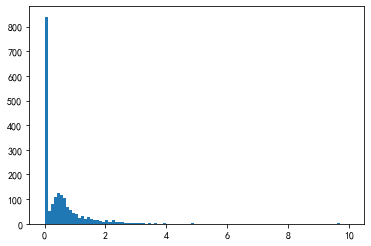

In [110]:
plt.hist(x = ipo_df['prob_online'], bins = 100, range = (0, 10))

In [68]:
ipo_df.head()

,ticker,name,price_issue,price_latest,prob_online,sub_size_online,subs_online,over_online,prob_offline,sub_size_offline,subs_offline,over_offline,size_total,list_premium,return_firstday,return_ipo,list_date,market,prob_all
54,603109,神驰机电,18.38,26.48,0.03515,93892836000,12131674,2844.98,0.011563,31714300000,7312,8648.57,36670000,0.2002,0.4402,0.03,2019-12-31,sh,0.035136
55,603995,甬金股份,22.52,33.26,0.04462,116334072000,11366524,2241.37,0.012767,45171000000,6986,7832.67,57670000,0.1998,0.4401,0.02,2019-12-24,sh,0.044600
56,601512,中新集团,9.67,11.56,0.08831,152755117000,11257993,1132.35,0.039017,38416500000,6439,2562.98,149890000,0.1996,0.4395,0.06,2019-12-20,sh,0.088282
57,603053,成都燃气,10.45,14.47,0.06641,120466360000,10990417,1505.81,0.022430,39629800000,7226,4458.30,88890000,0.2000,0.4402,0.06,2019-12-17,sh,0.066381
58,601658,邮储银行,5.50,4.58,1.25915,205383291000,8882002,79.42,4.773505,27087900000,2399,20.95,5947988200,0.0182,0.0200,0.02,2019-12-10,sh,1.260099


In [115]:
ipo_df['prob_online'][ipo_df['prob_online']>20]

656     24.68644
664     21.56808
1088    65.52084
Name: prob_online, dtype: float64

In [118]:
ipo_df['prob_offline'][ipo_df['prob_offline']>60]

632     66.666667
634     70.000000
680     63.391272
1078    90.909090
1868    66.670000
Name: prob_offline, dtype: float64

In [119]:
ipo_df['prob_all'][ipo_df['prob_all']>60]

1088    65.508859
Name: prob_all, dtype: float64